<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Non-negative-Matrix-Factorization-and-Latent-Dirichlet-Allocation" data-toc-modified-id="Non-negative-Matrix-Factorization-and-Latent-Dirichlet-Allocation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Non-negative Matrix Factorization and Latent Dirichlet Allocation</a></span></li><li><span><a href="#Imports" data-toc-modified-id="Imports-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Utilities" data-toc-modified-id="Utilities-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Utilities</a></span></li><li><span><a href="#Load-dataset" data-toc-modified-id="Load-dataset-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load dataset</a></span></li><li><span><a href="#Modelling" data-toc-modified-id="Modelling-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Modelling</a></span></li><li><span><a href="#NMF-with-Frobenius-norm" data-toc-modified-id="NMF-with-Frobenius-norm-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>NMF with Frobenius norm</a></span></li><li><span><a href="#NMF-with-Kullback-Leibler" data-toc-modified-id="NMF-with-Kullback-Leibler-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>NMF with Kullback-Leibler</a></span></li><li><span><a href="#LDA-models" data-toc-modified-id="LDA-models-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>LDA models</a></span></li><li><span><a href="#References" data-toc-modified-id="References-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>References</a></span></li></ul></div>

# Introduction
<hr style="border:2px solid black"> </hr>

<div class="alert alert-warning">
<font color=black>

**What?** Topics extraction

</font>
</div>

# Non-negative Matrix Factorization and Latent Dirichlet Allocation
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-info">
<font color=black>

- **Non-Negative Matrix Factorization (NMF)** Find two non-negative matrices, i.e. matrices with all non-negative elements, (W, H) whose product approximates the non-negative matrix X. This factorization can be used for example for dimensionality reduction, source separation or topic extraction. Non-negative matrix factorization (NMF): Less computationally expensive, but assumes fixed probability vectors of multinomials across documents, while LDA allows this to vary. If we believe the topic probabilities should remain fixed for each document, or in small data setting where additional variability from priors is too much, NMF might be better.
 
- **LDA** Latent Dirichlet Allocation is a generative statistical model that helps pick up similarities across a collection of different data parts. Similar sets of words occurring repeatedly may likely indicate topics. LDA assumes that each document is represented by a distribution of a fixed number of topics, and each topic is a distribution of words.
- **When are they used?** LDA and NMF have shown to be good starting points, but it takes quite some effort through hyperparameter tuning to create meaningful topics. On top of it, the output are not so intuitive.

    
- Other methods:
    - **Latent semantic indexing**: a variant of PCA/SVD. Again, much faster, but generally less accurate. Similar to NMF, but different loss constraint.
    - **Hierarchical Dirchlet Process**: Uses posterior inference to determine the number of topics for you
        
</font>
</div>

# Imports
<hr style="border:2px solid black"> </hr>

In [1]:
from time import time
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.datasets import fetch_20newsgroups
# Getting rid of the warning messages
import warnings
warnings.filterwarnings("ignore")

# Utilities
<hr style = "border:2px solid black" ></hr>

In [2]:
n_samples = 2000
n_features = 1000
n_components = 10
n_top_words = 20


def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

# Load dataset
<hr style = "border:2px solid black" ></hr>

In [5]:
"""
Load the 20 newsgroups dataset and vectorize it. We use a few heuristics
to filter out useless terms early on: the posts are stripped of headers,
footers and quoted replies, and common English words, words occurring in
only one document or in at least 95% of the documents are removed.
"""

'\nLoad the 20 newsgroups dataset and vectorize it. We use a few heuristics\nto filter out useless terms early on: the posts are stripped of headers,\nfooters and quoted replies, and common English words, words occurring in\nonly one document or in at least 95% of the documents are removed.\n'

In [3]:
print("Loading dataset...")
t0 = time()
data, _ = fetch_20newsgroups(shuffle=True, random_state=1,
                             remove=('headers', 'footers', 'quotes'),
                             return_X_y=True)
data_samples = data[:n_samples]
print("done in %0.3fs." % (time() - t0))

Loading dataset...
done in 43.310s.


In [5]:
len(data_samples)

2000

In [6]:
data_samples[0]

"Well i'm not sure about the story nad it did seem biased. What\nI disagree with is your statement that the U.S. Media is out to\nruin Israels reputation. That is rediculous. The U.S. media is\nthe most pro-israeli media in the world. Having lived in Europe\nI realize that incidences such as the one described in the\nletter have occured. The U.S. media as a whole seem to try to\nignore them. The U.S. is subsidizing Israels existance and the\nEuropeans are not (at least not to the same degree). So I think\nthat might be a reason they report more clearly on the\natrocities.\n\tWhat is a shame is that in Austria, daily reports of\nthe inhuman acts commited by Israeli soldiers and the blessing\nreceived from the Government makes some of the Holocaust guilt\ngo away. After all, look how the Jews are treating other races\nwhen they got power. It is unfortunate.\n"

# Modelling
<hr style="border:2px solid black"> </hr>

In [7]:
# Use tf-idf features for NMF.
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features,
                                   stop_words='english')
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))

# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=n_features,
                                stop_words='english')
t0 = time()
tf = tf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))
print()

Extracting tf-idf features for NMF...
done in 0.420s.
Extracting tf features for LDA...
done in 0.358s.



# NMF with Frobenius norm
<hr style = "border:2px solid black" ></hr>

Fitting the NMF model (Frobenius norm) with tf-idf features, n_samples=2000 and n_features=1000...
done in 0.288s.


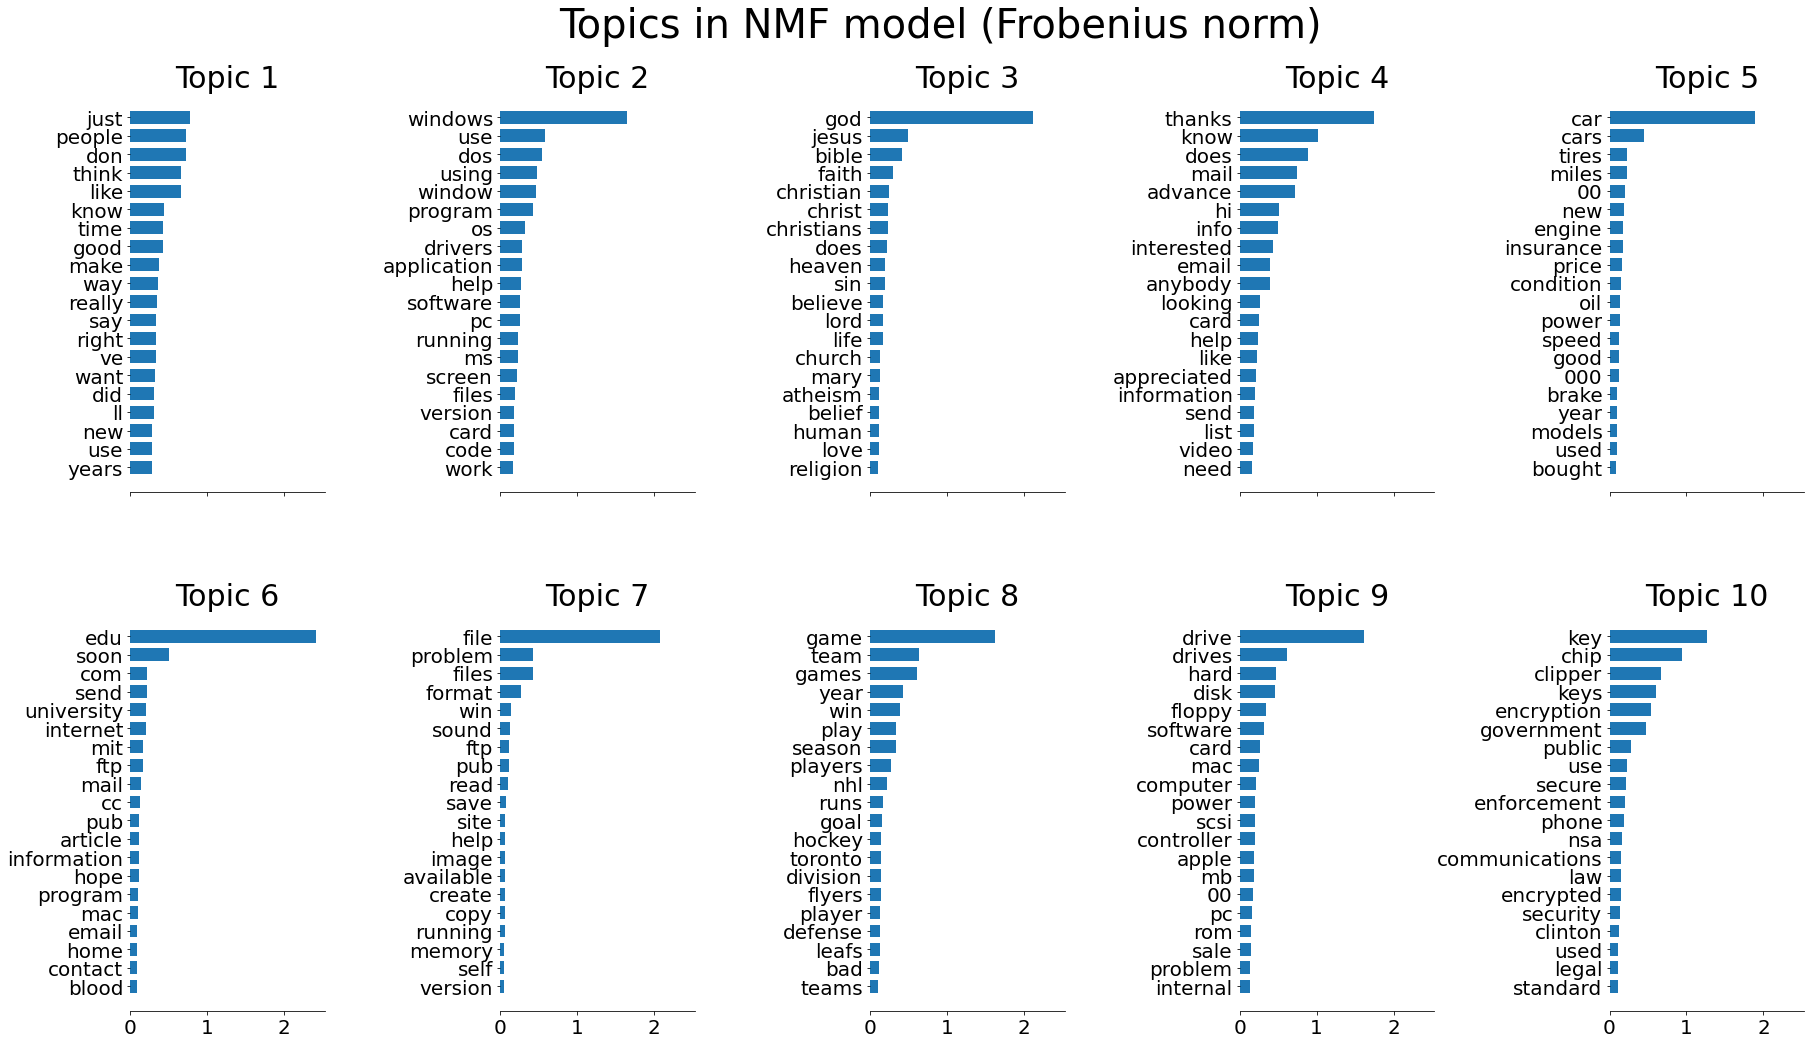

In [8]:
# Fit the NMF model
print("Fitting the NMF model (Frobenius norm) with tf-idf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
t0 = time()
nmf = NMF(n_components=n_components, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf)
print("done in %0.3fs." % (time() - t0))


tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_top_words(nmf, tfidf_feature_names, n_top_words,
               'Topics in NMF model (Frobenius norm)')

# NMF with Kullback-Leibler
<hr style = "border:2px solid black" ></hr>



 Fitting the NMF model (generalized Kullback-Leibler divergence) with tf-idf features, n_samples=2000 and n_features=1000...
done in 1.225s.


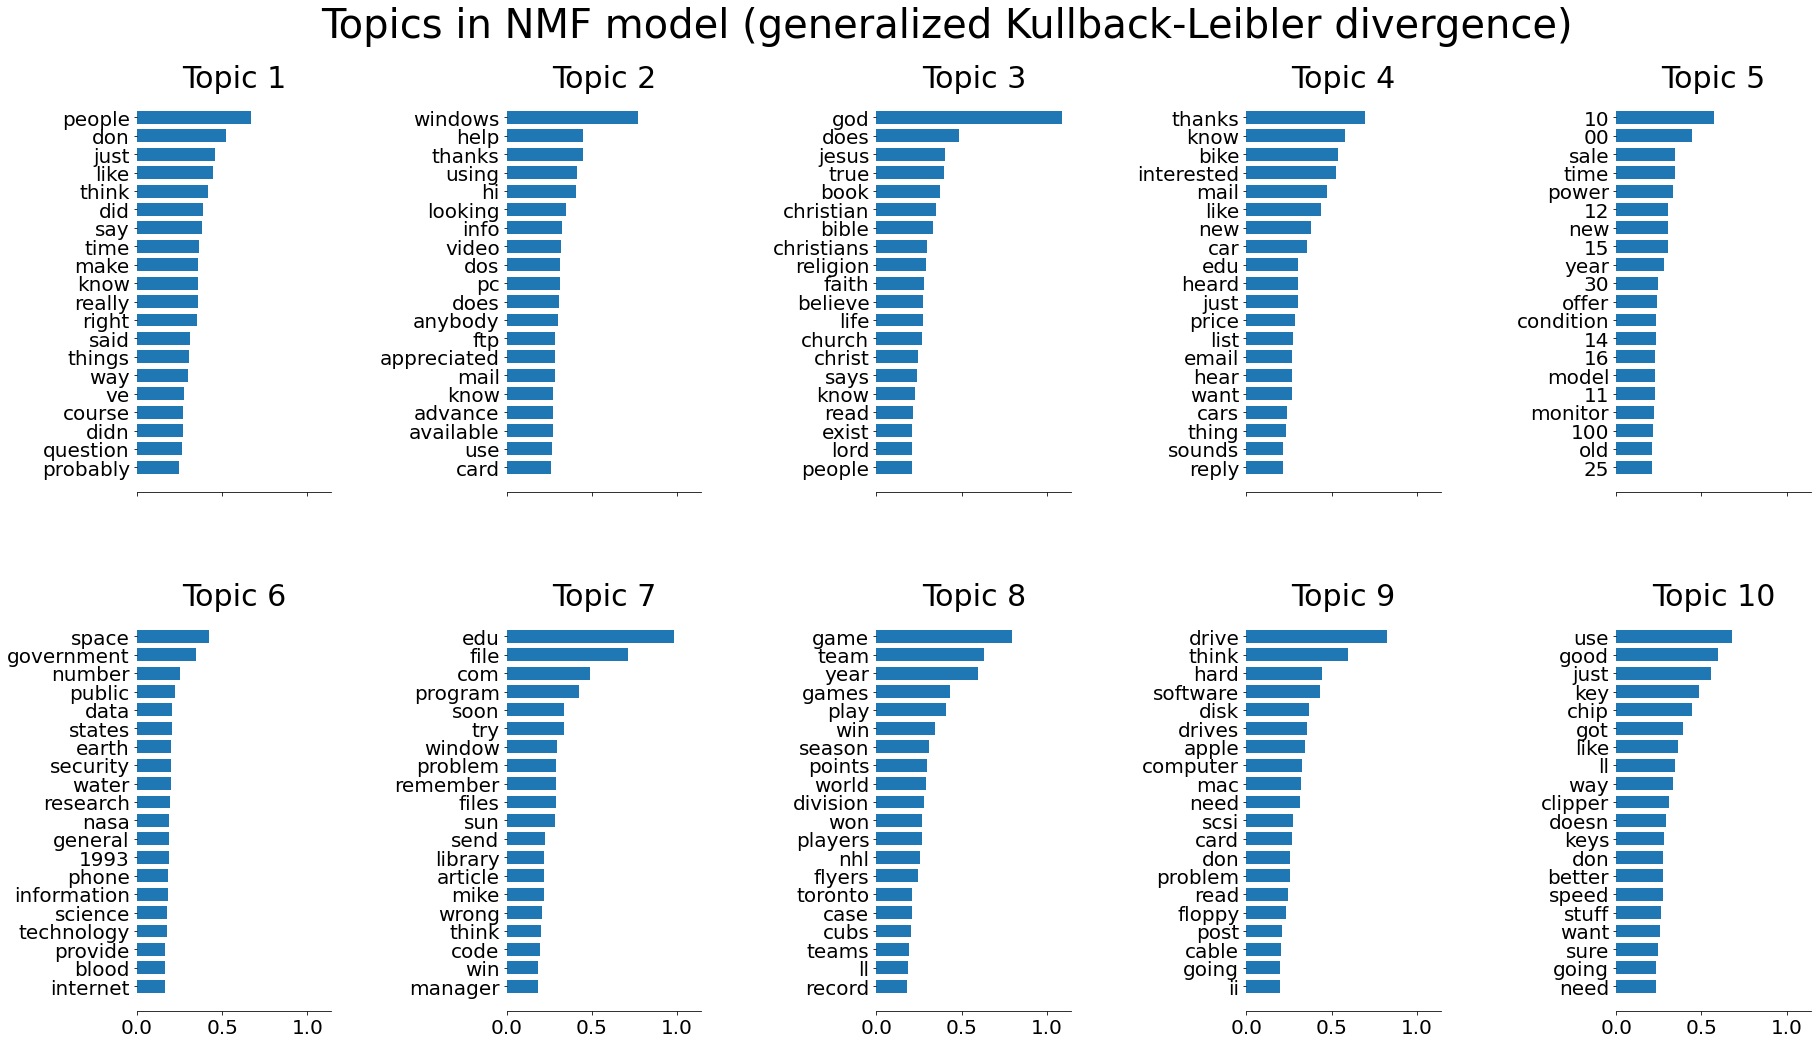

In [10]:
# Fit the NMF model
print('\n' * 2, "Fitting the NMF model (generalized Kullback-Leibler "
      "divergence) with tf-idf features, n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
t0 = time()
nmf = NMF(n_components=n_components, random_state=1,
          beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1,
          l1_ratio=.5).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_top_words(nmf, tfidf_feature_names, n_top_words,
               'Topics in NMF model (generalized Kullback-Leibler divergence)')

# LDA models
<hr style = "border:2px solid black" ></hr>



 Fitting LDA models with tf features, n_samples=2000 and n_features=1000...
done in 4.138s.


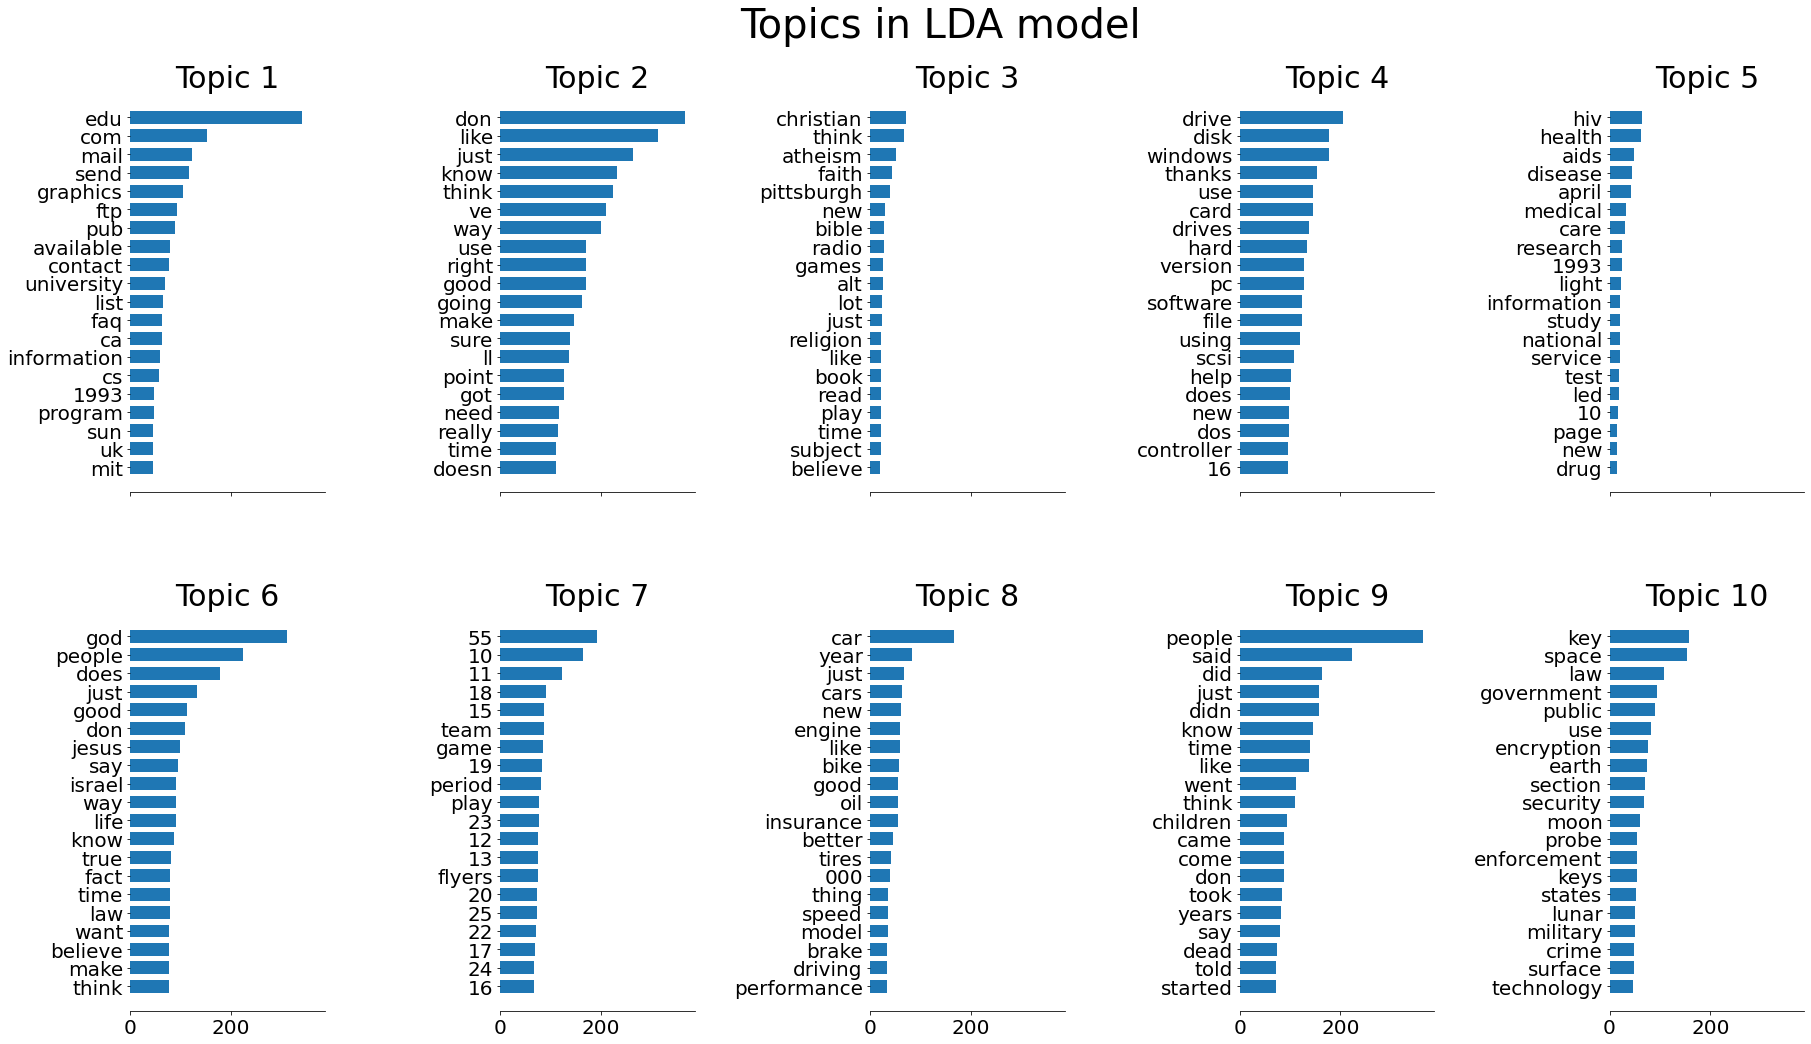

In [11]:
print('\n' * 2, "Fitting LDA models with tf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
lda = LatentDirichletAllocation(n_components=n_components, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
t0 = time()
lda.fit(tf)
print("done in %0.3fs." % (time() - t0))

tf_feature_names = tf_vectorizer.get_feature_names()
plot_top_words(lda, tf_feature_names, n_top_words, 'Topics in LDA model')

# References
<hr style="border:2px solid black"> </hr>

<div class="alert alert-warning">
<font color=black>

- https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py
- https://towardsdatascience.com/6-tips-to-optimize-an-nlp-topic-model-for-interpretability-20742f3047e2

</font>
</div>